### Optimal control of the Wilson-Cowan model
This notebook shows how to compute the optimal control (OC) signal for the Wilson-Cowan model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.ww import WWModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_ww
from neurolib.utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = WWModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.0
model.params["r_exc"] = np.array([[x_init]])
model.params["r_inh"] = np.array([[y_init]])

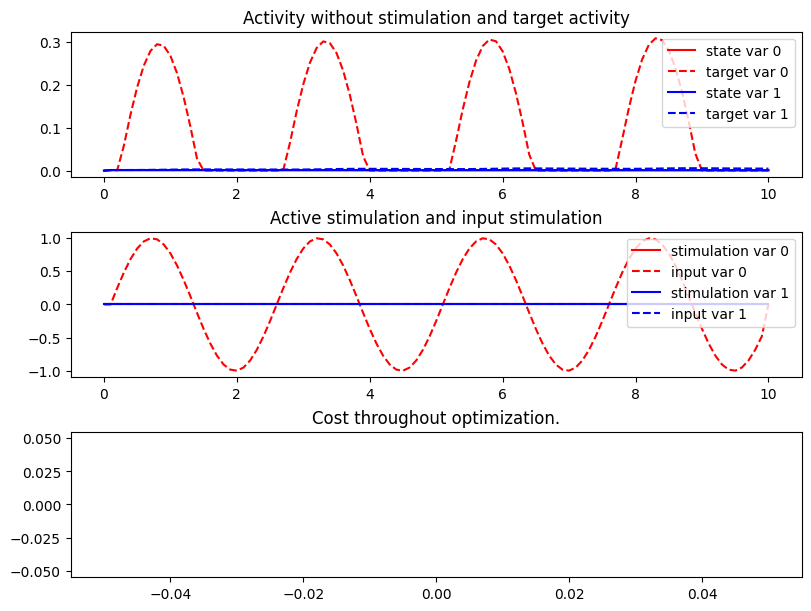

In [4]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_current"] = input
model.params["inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["r_exc"], model.params["r_inh"], model.params["se_init"], model.params["si_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.r_exc, model.r_inh, model.se, model.si), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["exc_current"] = zero_input
model.params["inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["r_exc"], model.params["r_inh"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.r_exc, model.r_inh), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: nan
Final cost : nan


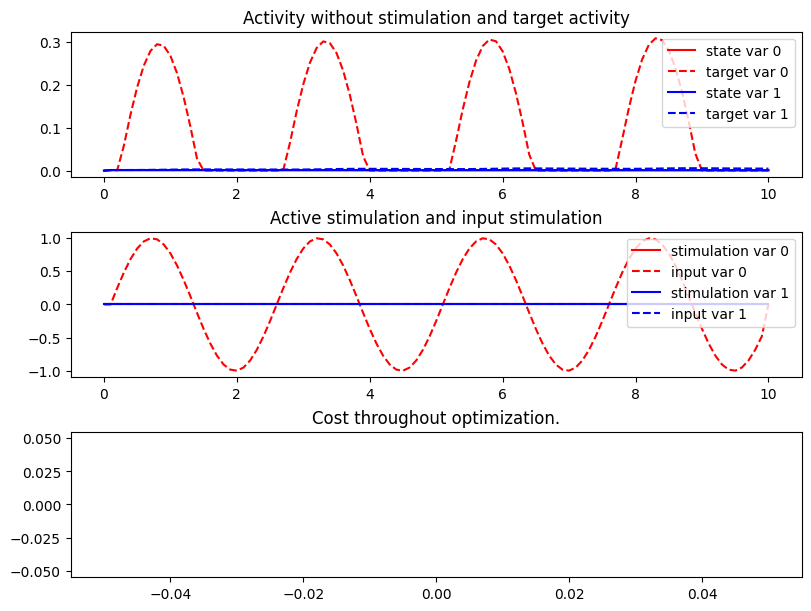

In [6]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_current"] = zero_input
model.params["inh_current"] = zero_input

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_ww.OcWw(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(0)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 1.409261374589448e-07
Cost in iteration 25: 1.3051113114486073e-07
Cost in iteration 50: 1.2069164098268257e-07
Cost in iteration 75: 1.1215971283577606e-07
Cost in iteration 100: 1.0456327452784617e-07
Final cost : 1.0456327452784617e-07


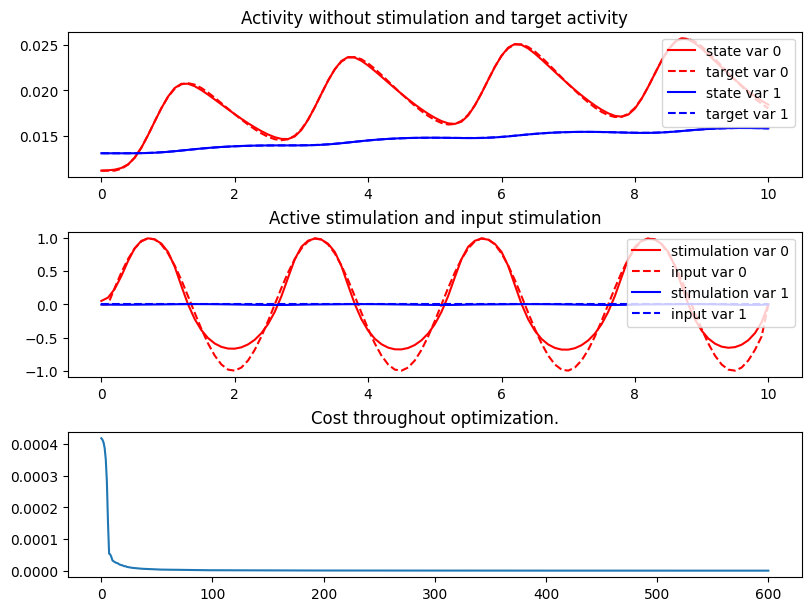

In [5]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

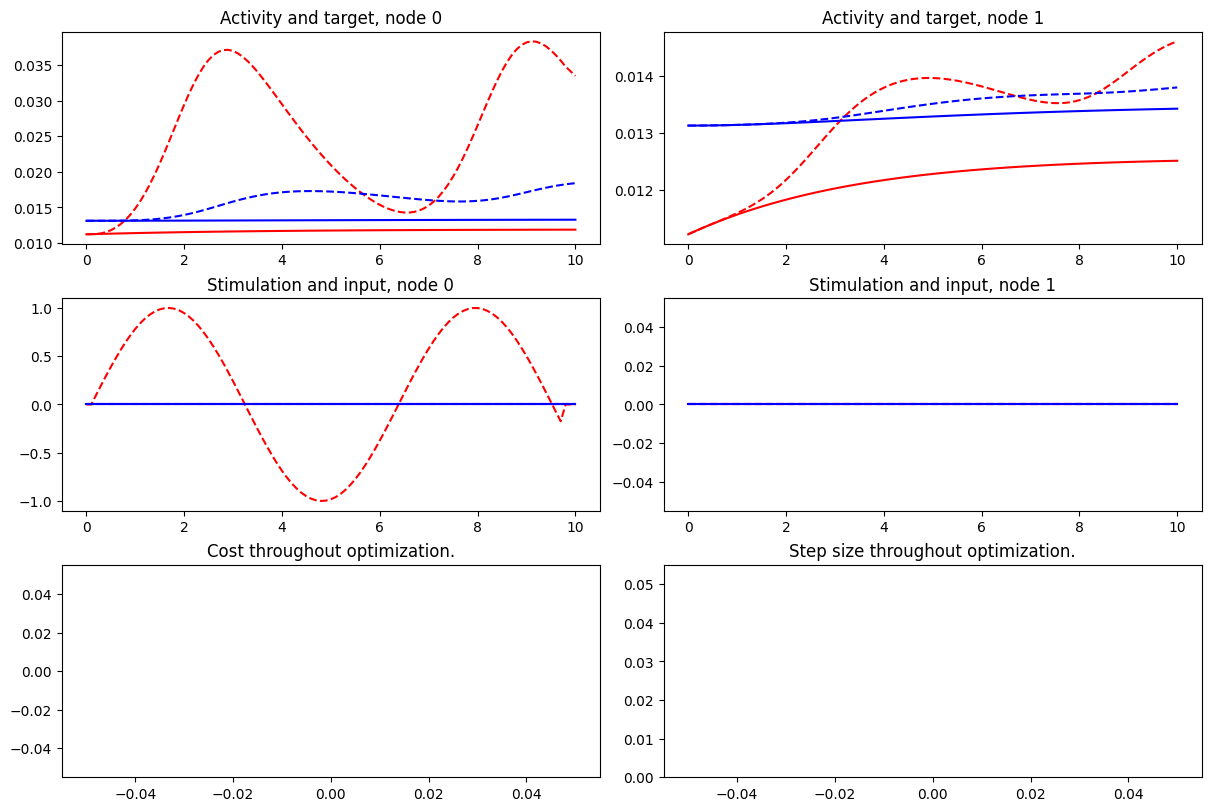

In [6]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WWModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params.K_gl = 5.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["r_exc"] = np.vstack( [x_init, x_init] )
model.params["r_inh"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_current"] = input_nw[:,0,:]
model.params["inh_current"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["r_exc"], model.params["r_inh"]), axis=1)[:,:, np.newaxis], np.stack( (model.r_exc, model.r_inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_current"] = zero_input_nw[:,0,:]
model.params["inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["r_exc"], model.params["r_inh"]), axis=1)[:,:, np.newaxis], np.stack( (model.r_exc, model.r_inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 8.117061134315108e-06
Cost in iteration 25: 4.0329637221407195e-07
Cost in iteration 50: 2.133706589679289e-07
Cost in iteration 75: 1.0846418185856119e-07
Cost in iteration 100: 6.237553898673198e-08
Cost in iteration 125: 3.607365058691262e-08
Cost in iteration 150: 2.2496421814207724e-08
Cost in iteration 175: 1.5886138922670738e-08
Cost in iteration 200: 1.1727415781910453e-08
Cost in iteration 225: 9.005487959890062e-09
Cost in iteration 250: 7.191281120908631e-09
Cost in iteration 275: 5.835744371001404e-09
Cost in iteration 300: 4.915806895112334e-09
Cost in iteration 325: 4.206672224203755e-09
Cost in iteration 350: 3.6916483993194285e-09
Cost in iteration 375: 3.2948161905145206e-09
Cost in iteration 400: 2.9837006122863342e-09
Cost in iteration 425: 2.7310136209212046e-09
Cost in iteration 450: 2.5267282859627983e-09
Cost in iteration 475: 2.352356874896669e-09
Cost in iteration 500: 2.2057268519628175e-09
Final 

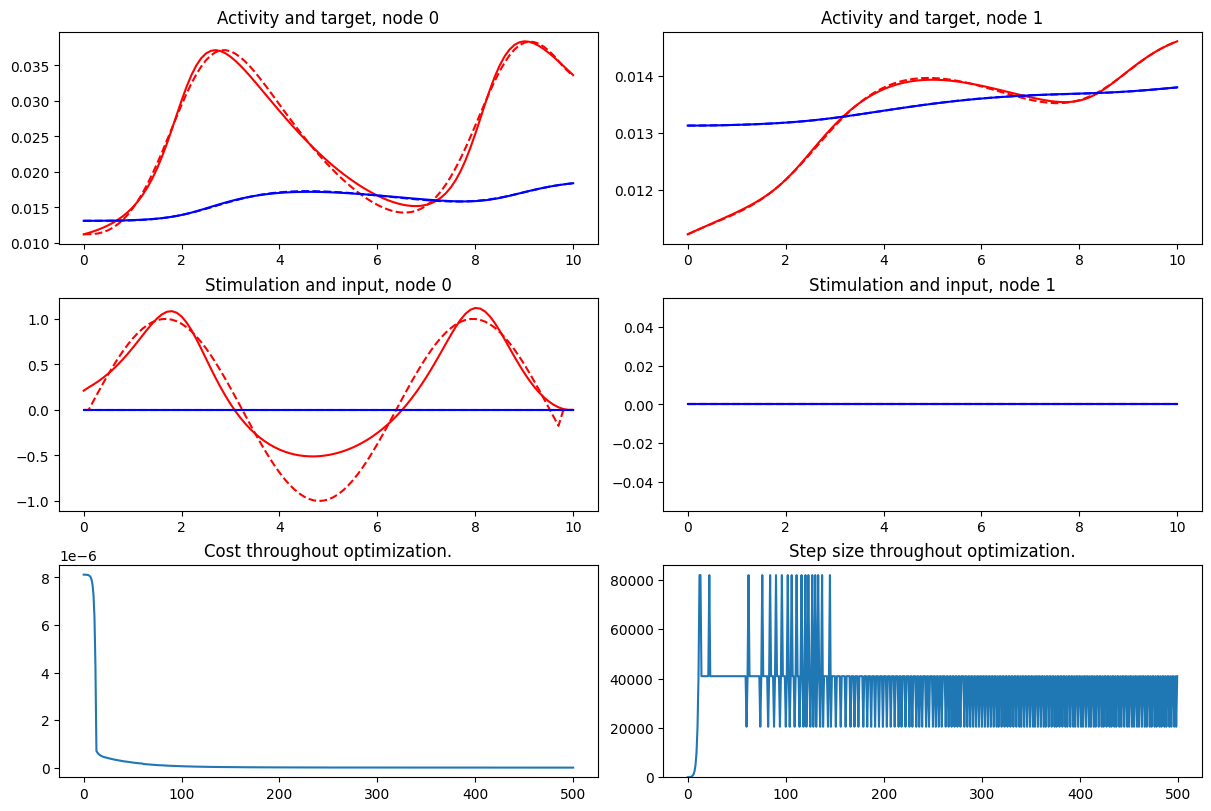

In [7]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_current"] = zero_input_nw[:,0,:]
model.params["inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_ww.OcWw(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 2.2057268519628175e-09
Cost in iteration 25: 2.079569265893922e-09


Cost in iteration 50: 1.969986550217457e-09
Cost in iteration 75: 1.874389888067335e-09
Cost in iteration 100: 1.7855706988225455e-09
Final cost : 1.7855706988225455e-09


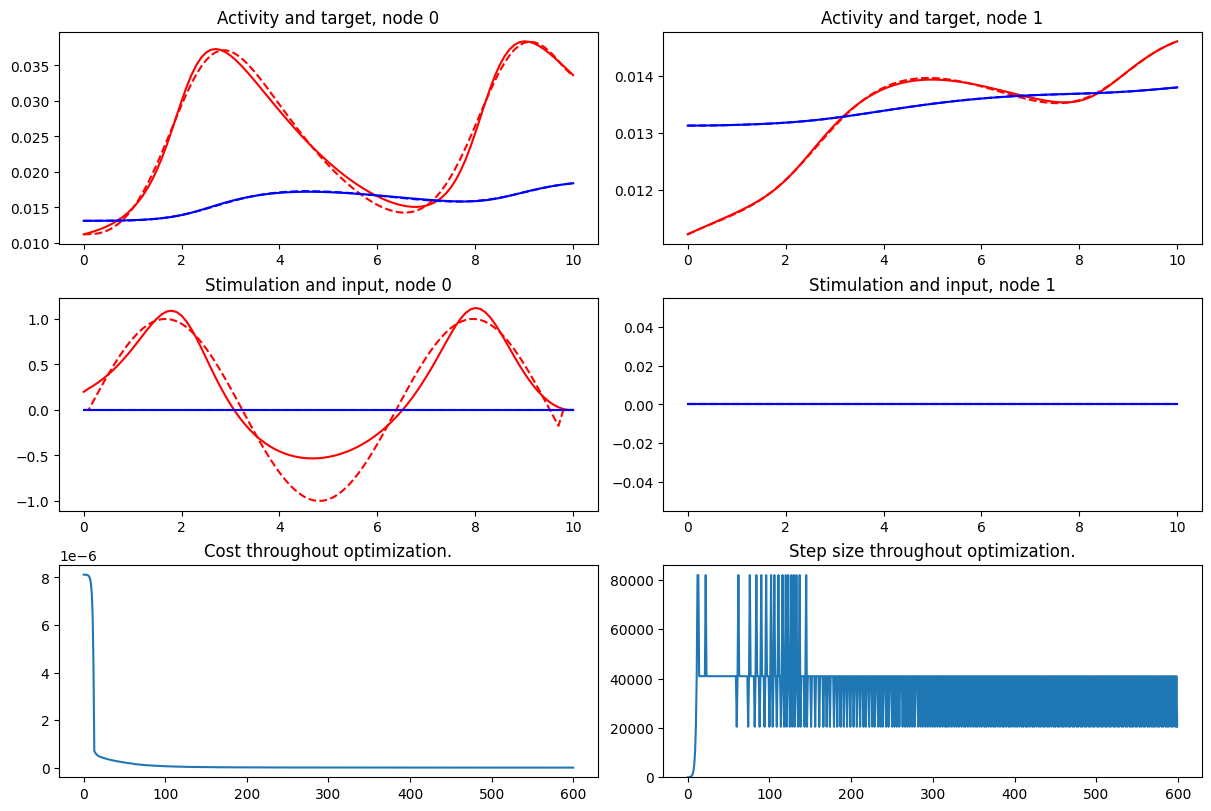

In [8]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

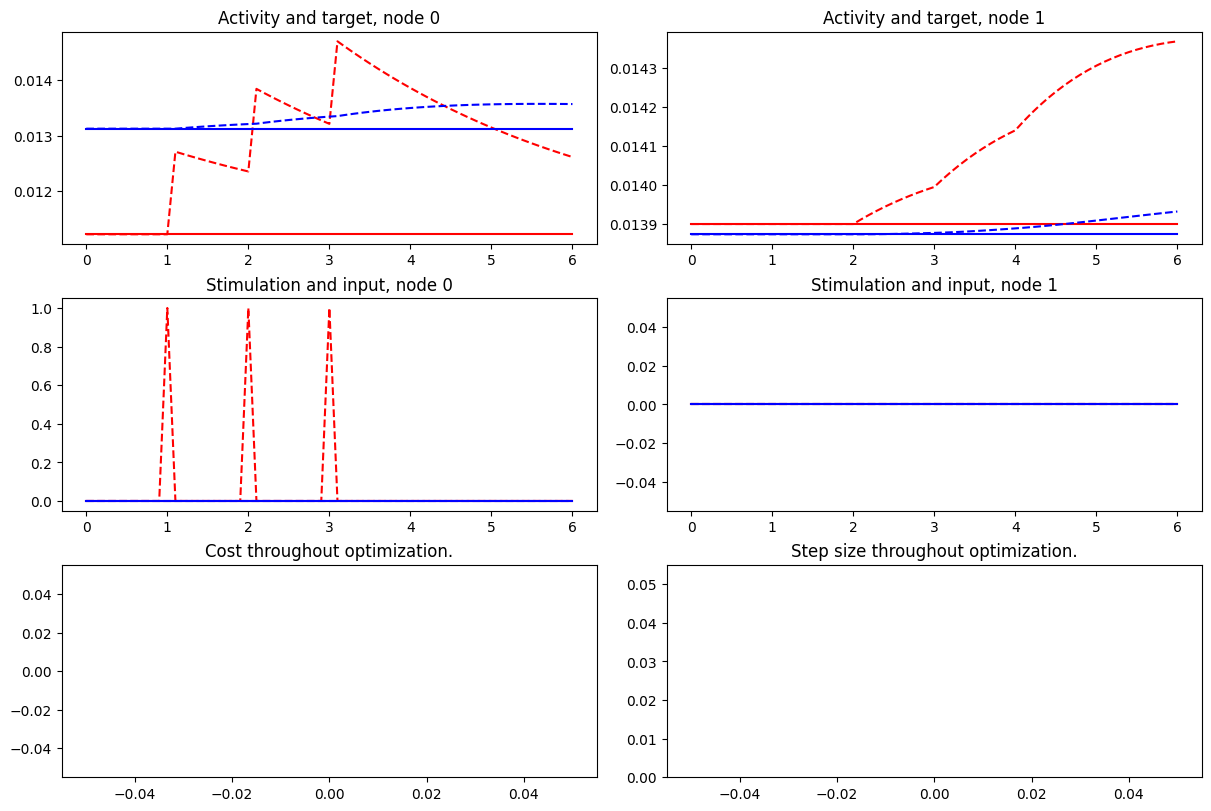

In [9]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = WWModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 10.

model.run()

e0 = model.r_exc[0,-1]
e1 = model.r_exc[1,-1]
i0 = model.r_inh[0,-1]
i1 = model.r_inh[1,-1]

maxdelay = model.getMaxDelay()

model.params["r_exc"] = np.array([[e0] * (maxdelay + 1), [e1] * (maxdelay + 1) ])
model.params["r_inh"] = np.array([[i0] * (maxdelay + 1), [i1] * (maxdelay + 1) ])

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_current"] = input_nw[:,0,:]
model.params["inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["r_exc"][:,-1], model.params["r_inh"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.r_exc, model.r_inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_current"] = zero_input_nw[:,0,:]
model.params["inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (np.stack( (model.params["r_exc"][:,-1], model.params["r_inh"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.r_exc, model.r_inh), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 1.792835053390993e-07
Cost in iteration 25: 3.224858708247228e-10
Cost in iteration 50: 1.0235990384283723e-10
Cost in iteration 75: 8.627681277851615e-11
Cost in iteration 100: 8.09708890397755e-11
Cost in iteration 125: 6.901547805762654e-11
Cost in iteration 150: 6.563898918059379e-11
Cost in iteration 175: 6.358322097910284e-11
Cost in iteration 200: 5.819126634851626e-11
Cost in iteration 225: 5.598411882794661e-11
Cost in iteration 250: 5.458351655389417e-11
Cost in iteration 275: 5.101837452145287e-11
Cost in iteration 300: 4.9526343719852504e-11
Cost in iteration 325: 4.872279762423021e-11
Cost in iteration 350: 4.599347400927492e-11
Cost in iteration 375: 4.5049466495032303e-11
Cost in iteration 400: 4.32863678958512e-11
Cost in iteration 425: 4.241565430129624e-11
Cost in iteration 450: 4.121896579349796e-11
Cost in iteration 475: 4.036542019862459e-11
Cost in iteration 500: 3.990804399212831e-11
Final cost : 3.9

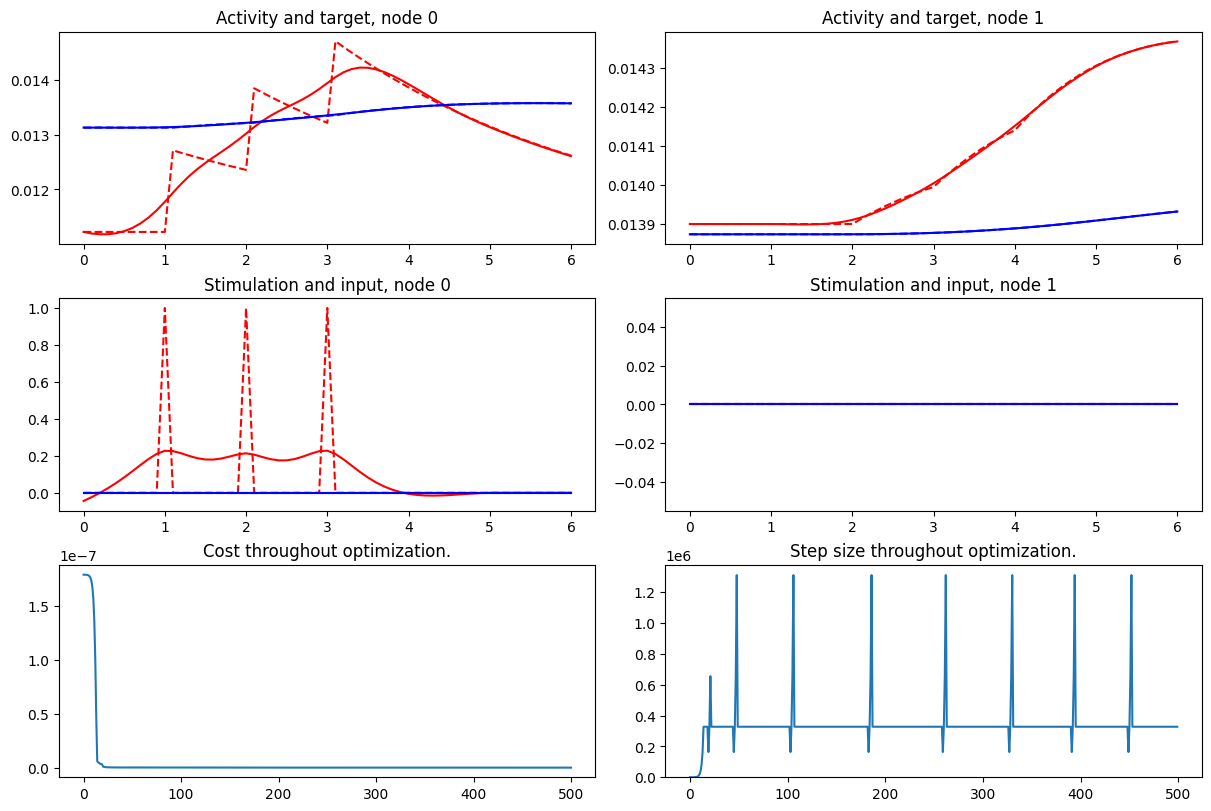

In [10]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_ww.OcWw(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 3.990804399212831e-11
Cost in iteration 25: 3.8701660107380814e-11
Cost in iteration 50: 3.8275743610357815e-11
Cost in iteration 75: 3.731362663528545e-11
Cost in iteration 100: 3.694171527929222e-11
Final cost : 3.694171527929222e-11


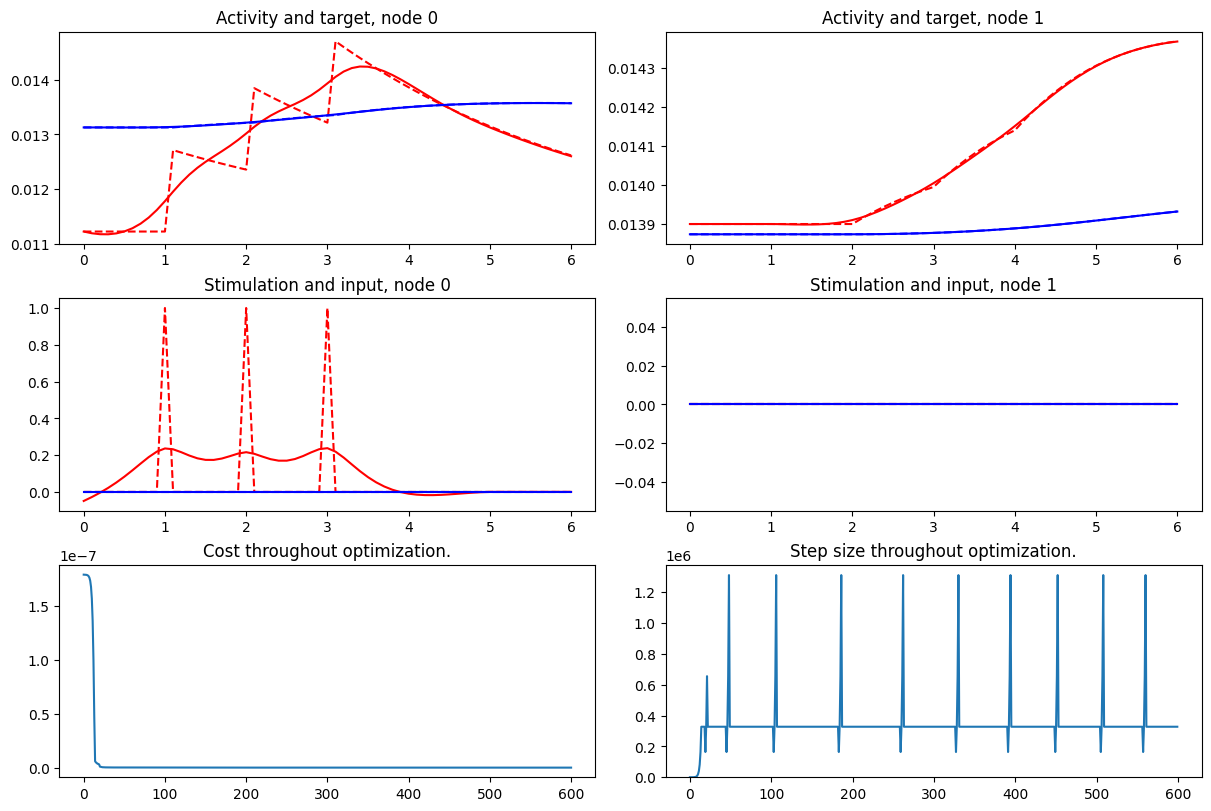

In [11]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 500 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)